In [1]:
import uproot
import awkward as ak
import numpy as np
import pandas as pd
import numba as nb
import matplotlib.pyplot as plt

import time
import gc
# from memory_profiler import profile

In [2]:
%load_ext memory_profiler
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

### import global vars

In [3]:
from utils import add_vars_to_taus, get_batch_yielder

In [4]:
from transform_inputs import fill_branches, constituent_types
from transform_inputs import grid_types, grid_dim, n_cells, cell_size

In [5]:
len(fill_branches['ele']) + len(fill_branches['muon']) + len(fill_branches['pfCand'])

182

In [6]:
grid_size, grid_left, grid_right = {}, {}, {}
for grid_type in grid_types:
    grid_size[grid_type] = cell_size[grid_type] * n_cells[grid_type]
    grid_left[grid_type], grid_right[grid_type] = - grid_size[grid_type] / 2, grid_size[grid_type] / 2

### fetch data batch for tests

In [7]:
batch_size = 500
batch_yielder = get_batch_yielder('data/ShuffleMergeSpectral_1.root', 'taus', batch_size)

In [8]:
for taus in batch_yielder:
    break

In [9]:
taus

<Array [{run: 1, lumi: 4444, ... ] type='500 * {"run": uint32, "lumi": uint32, "...'>

### fill tensor function

In [10]:
@nb.njit
def fill_feature_tensor(tensor_to_fill, i_feature, taus_feature, c_deta, c_dphi, grid_left, grid_right, cell_size):
    for i_tau in range(len(taus_feature)):
        for i_const in range(len(taus_feature[i_tau])):
            mask = (c_deta[i_tau][i_const] > grid_left) & (c_deta[i_tau][i_const] < grid_right)
            mask *= (c_dphi[i_tau][i_const] > grid_left) & (c_dphi[i_tau][i_const] < grid_right)
            if mask:
                i_eta = np.int(np.floor((c_deta[i_tau][i_const] - grid_left) / cell_size))
                i_phi = np.int(np.floor((c_dphi[i_tau][i_const] - grid_left) / cell_size))
                tensor_to_fill[i_tau, i_eta, i_phi, i_feature] = taus_feature[i_tau][i_const]

In [11]:
c_type = 'pfCand'
grid_type = 'inner'

In [12]:
# %%timeit
c_deta = taus[c_type]['eta'] - taus['tau_eta']
c_dphi = taus[c_type]['phi'] - taus['tau_phi']

In [13]:
branches = taus[c_type].fields[:40]

In [14]:
feature_tensor = np.zeros((len(taus), n_cells[grid_type], n_cells[grid_type], len(branches)))

In [15]:
fill_feature_tensor(feature_tensor, 0, taus[c_type, 'pt'], c_deta, c_dphi, 
                    grid_left[grid_type], grid_right[grid_type], cell_size[grid_type])

In [16]:
%%timeit
for i_feature, branch in enumerate(5*branches):
    fill_feature_tensor(feature_tensor, i_feature, taus[c_type, branch], c_deta, c_dphi, 
                    grid_left[grid_type], grid_right[grid_type], cell_size[grid_type])

98 ms ± 4.71 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### full scale

#### NOTE: don't forget postfactum masking of outer grid with 0 at inner indices!

In [34]:
batch_size = 500
n_batches = 10
batch_yielder = get_batch_yielder('data/ShuffleMergeSpectral_1.root', 'taus', batch_size)

In [35]:
# dictionaries to store timing
preprocess_times = {c_key: [] for c_key in constituent_types} 
# get_mask_times = {key: {c_key: [] for c_key in constituent_types} for key in grid_types}
# get_fill_indices_times = {key: {c_key: [] for c_key in constituent_types} for key in grid_types}
fill_feature_times = {key: {c_key: [] for c_key in constituent_types} for key in grid_types}
# fill_tensor_times = {key: {c_key: [] for c_key in constituent_types} for key in grid_types}

In [36]:
# initialize tensors to be filled 
grid_tensors = {key: {} for key in grid_types}
for c_type in constituent_types:
    for grid_type in grid_types:
        grid_tensors[grid_type][c_type] = np.zeros((batch_size, n_cells[grid_type], n_cells[grid_type], len(fill_branches[c_type])))

In [37]:
# %%timeit
program_starts = time.time()
batch_done = program_starts
for i_batch, taus in enumerate(batch_yielder):
    for c_type in constituent_types:
        before_preprocessing = time.time()
        add_vars_to_taus(taus, c_type)
        after_preprocessing = time.time()
        preprocess_times[c_type].append(after_preprocessing - before_preprocessing)  
        for grid_type in grid_types:
            for i_feature, feature in enumerate(fill_branches[c_type]):
                before_fill_feature = time.time()
                fill_feature_tensor(grid_tensors[grid_type][c_type], i_feature, taus[c_type, feature], 
                                                     taus[c_type, 'deta'], taus[c_type, 'dphi'], 
                                                     grid_left[grid_type], grid_right[grid_type], cell_size[grid_type])
                after_fill_feature = time.time()
                fill_feature_times[grid_type][c_type].append(after_fill_feature - before_fill_feature) 
    grid_tensors[grid_type][c_type][:, 8:13, 8:13, :] = 0 # at the moment bad way of inner grid masking
    print(f'returned {i_batch}th batch, time passed: {after_fill_feature - batch_done}')
    batch_done = after_fill_feature
    if i_batch == n_batches - 1:
        break
program_ends = time.time()

returned 0th batch, time passed: 2.593766689300537
returned 1th batch, time passed: 0.7501311302185059
returned 2th batch, time passed: 0.7530882358551025
returned 3th batch, time passed: 0.8402588367462158
returned 4th batch, time passed: 0.7288265228271484
returned 5th batch, time passed: 0.776627779006958
returned 6th batch, time passed: 0.8068127632141113
returned 7th batch, time passed: 0.7790870666503906
returned 8th batch, time passed: 0.7301685810089111
returned 9th batch, time passed: 0.7708718776702881


In [38]:
print(f'Processed {n_batches}*{batch_size} taus in {program_ends - program_starts} seconds\n')
for c_type in constituent_types:
    print(f'=== {c_type}')
    print(f'median preprocess time: {np.median(preprocess_times[c_type])}\n')
    for grid_type in grid_types:
        print(f'------- {grid_type} cell')
#         print(f'median get_grid_mask() time: {np.median(get_mask_times[grid_type][c_type])}')
#         print(f'median get_fill_indices() time: {np.median(get_fill_indices_times[grid_type][c_type])}')
        print(f'median fill_feature_tensor() time: {np.median(fill_feature_times[grid_type][c_type])}')
#         print(f'median fill tensor time: {np.median(fill_tensor_times[grid_type][c_type])}')
        print()
    print()

Processed 10*500 taus in 9.531000852584839 seconds

=== ele
median preprocess time: 0.005025506019592285

------- inner cell
median fill_feature_tensor() time: 0.000888824462890625

------- outer cell
median fill_feature_tensor() time: 0.0008866786956787109


=== muon
median preprocess time: 0.004919290542602539

------- inner cell
median fill_feature_tensor() time: 0.0008873939514160156

------- outer cell
median fill_feature_tensor() time: 0.0008885860443115234


=== pfCand
median preprocess time: 0.0051680803298950195

------- inner cell
median fill_feature_tensor() time: 0.0010455846786499023

------- outer cell
median fill_feature_tensor() time: 0.0012464523315429688




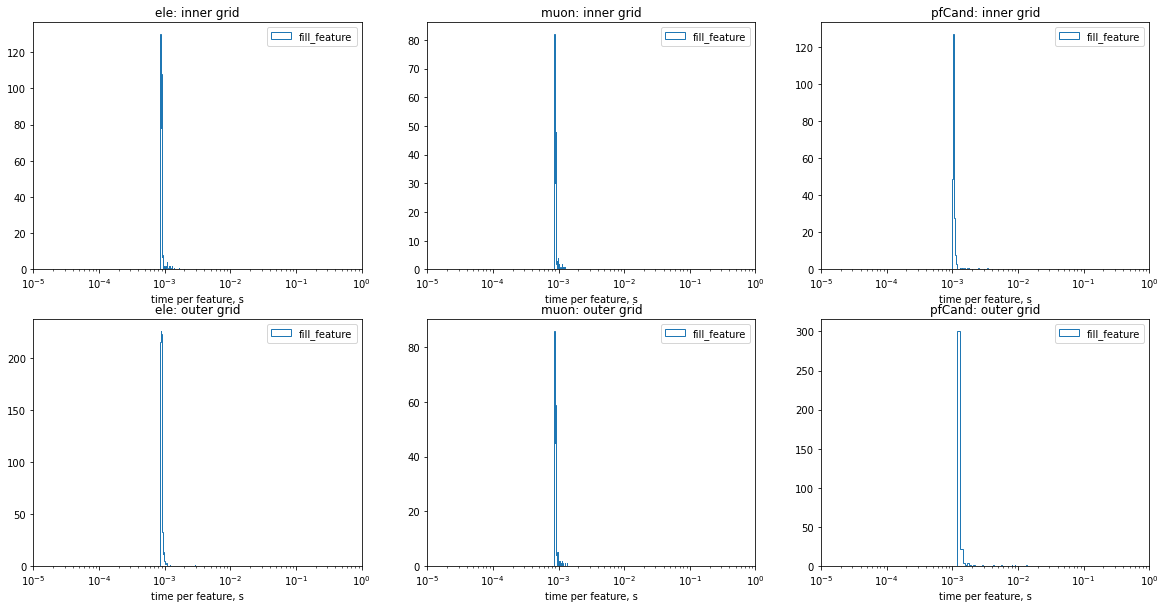

In [39]:
f, ax = plt.subplots(len(grid_types), len(constituent_types), figsize=(20,10))
for i, grid_type in enumerate(grid_types):
    for j, c_type in enumerate(constituent_types):
        ax[i,j].hist(fill_feature_times[grid_type][c_type], histtype='step', bins=100, label='fill_feature')
        ax[i,j].set_xlabel('time per feature, s')
        ax[i,j].set_xscale('log')
        ax[i,j].set_xlim((1e-5, 1e0))
        ax[i,j].set_title(f'{c_type}: {grid_type} grid')
        ax[i,j].legend()

* non-linear scaling with the batch_size, ~between `O(N)` and `O(log(N))`
* ~linear with the number of batches
* sizeable fraction of time is the uploading of a batch in between baskets

In [45]:
27*(np.log10(5000)/np.log10(500))**2

50.71416360750759

### validation

In [23]:
# note: rerun filling step once again for 1 single batch, otherwise will get multiple fills

In [24]:
from utils import derive_cell_indices, derive_grid_mask

In [25]:
grid_type = 'inner'
c_type = 'pfCand'
tau_i = 20
branches = taus[c_type].fields[:50]

In [26]:
for dim in grid_dim:
    taus[c_type, f'{grid_type}_grid_indices_{dim}'] = derive_cell_indices(taus, c_type, grid_left[grid_type], cell_size[grid_type], dim)

In [27]:
grid_mask = derive_grid_mask(taus, c_type, grid_left[grid_type], grid_right[grid_type])

In [28]:
indices_eta = ak.values_astype(taus[c_type, f'{grid_type}_grid_indices_eta'], 'int32')[grid_mask]
indices_phi = ak.values_astype(taus[c_type, f'{grid_type}_grid_indices_phi'], 'int32')[grid_mask]

In [29]:
grid_coord = ak.to_pandas(taus[c_type, ['deta', 'dphi']][grid_mask][tau_i])
grid_coord

,deta,dphi
entry,,
0,0.000000,0.000000
1,0.085330,-0.043547
2,0.082949,-0.047562
3,-0.088443,0.004299


In [30]:
feature_i = 5

In [31]:
# eta_indices = taus[c_type, f"{grid_type}_grid_indices_eta"][grid_mask][tau_i].tolist()
# phi_indices = taus[c_type, f"{grid_type}_grid_indices_phi"][grid_mask][tau_i].tolist()
vals = taus[c_type, fill_branches[c_type][feature_i]][grid_mask][tau_i]
for x,y,v in sorted(zip(indices_eta[tau_i], indices_phi[tau_i], vals)):
    print(x,y,v)

1 5 1.2127444744110107
5 5 1.3011871576309204
9 3 1.384136438369751
9 3 1.3865169286727905


In [32]:
len(vals), len(indices_eta[tau_i]), len(indices_phi[tau_i])

(4, 4, 4)

In [33]:
nonzero_idx_eta = np.argwhere(grid_tensors[grid_type][c_type][tau_i, :, :, feature_i])[:, 0]
nonzero_idx_phi = np.argwhere(grid_tensors[grid_type][c_type][tau_i, :, :, feature_i])[:, 1]
nonzero_vals = grid_tensors[grid_type][c_type][tau_i, nonzero_idx_eta, nonzero_idx_phi, feature_i]
for x,y,v in sorted(zip(nonzero_idx_eta, nonzero_idx_phi, nonzero_vals)):
    print(x,y,v)

1 5 1.2127444744110107
5 5 1.3011871576309204
9 3 1.384136438369751


### [dev] parallelising numba

In [122]:
from numba import prange

### [dev] masking inner grid

In [104]:
%%timeit
grid_tensors['outer']['ele'][:, 5:15, 5:15, :] = 0

4.26 ms ± 97.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [111]:
@nb.njit
def mask_inner_grid(grid_tensor):
    for i_tau in range(grid_tensor.shape[0]):
        for i_feature in range(grid_tensor.shape[-1]):
            grid_tensor[i_tau, 5:15, 5:15, i_feature] = 0

In [112]:
mask_inner_grid(grid_tensors['outer']['ele'])

In [113]:
%%timeit
mask_inner_grid(grid_tensors['outer']['ele'])

5.85 ms ± 365 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### [dev] speed up loading

* read separately each feature into ak 

In [69]:
type(batch_yielder)

generator

In [71]:
%%timeit
next(batch_yielder)

360 ms ± 32.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [76]:
import concurrent.futures

In [77]:
executor = concurrent.futures.ThreadPoolExecutor()

In [103]:
%%timeit
t = uproot.open('data/ShuffleMergeSpectral_1.root:taus', num_workers=10)

291 ms ± 2.58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [104]:
%%timeit
f = uproot.open('data/ShuffleMergeSpectral_1.root')

377 µs ± 9.62 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [105]:
%%timeit
t = f['taus']

9.11 µs ± 29.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [106]:
f = uproot.open('data/ShuffleMergeSpectral_1.root')
t = f['taus']

In [147]:
%%timeit
batch_yielder = t.iterate('pfCand_pt', library="ak", step_size=1000)

431 ns ± 5.64 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [148]:
%%timeit
for taus_c in batch_yielder:
    break

25.8 ns ± 0.351 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [149]:
taus_c

<Array [{pfCand: [{pt: 0.778}, ... pt: 1.56}]}] type='1000 * {"pfCand": var * {"...'>

In [140]:
%%timeit
taus['pfCand', 'dummy'] = taus['pfCand', 'pt']*taus['pfCand', 'eta']

2.04 ms ± 98.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [141]:
b = f['taus'].array(['pfCand'])

KeyInFileError: not found: 'pfCand'

    Available keys: 'pfCand_pt', 'pfCand_dz', 'pfCand_eta', 'pfCand_phi', 'pfCand_dxy', 'pfCand_mass', 'pfCand_time', 'pfCand_pdgId', 'run', 'npv', 'npu', 'pv_ndof', 'pfCand_tauIso', 'pfCand_fromPV', 'pfCand_charge', 'pv_x'...

in file data/ShuffleMergeSpectral_1.root
in object /taus;30

### [dev] filling multiple

In [130]:
@nb.njit
def fill_multiple_features_tensor(tensor_to_fill, i_feature, taus_feature, c_deta, c_dphi, grid_left, grid_right, cell_size):
    for k in range(200):
        for i_tau in range(len(taus_feature)):
            for i_const in range(len(taus_feature[i_tau])):
                eta_mask = (c_deta[i_tau][i_const] > grid_left) & (c_deta[i_tau][i_const] < grid_right)
                phi_mask = (c_dphi[i_tau][i_const] > grid_left) & (c_dphi[i_tau][i_const] < grid_right)
                if eta_mask*phi_mask:
                    i_eta = np.int(np.floor((c_deta[i_tau][i_const] - grid_left) / cell_size))
                    i_phi = np.int(np.floor((c_dphi[i_tau][i_const] - grid_left) / cell_size))
                    tensor_to_fill[i_tau, i_eta, i_phi, i_feature] = taus_feature[i_tau][i_const]

In [131]:
fill_multiple_features_tensor(feature_tensor, 0, taus[c_type, 'pt'], c_deta, c_dphi, 
                    grid_left[grid_type], grid_right[grid_type], cell_size[grid_type])

NameError: name 'feature_tensor' is not defined

In [50]:
%%timeit
fill_multiple_features_tensor(feature_tensor, 0, taus[c_type, 'pt'], c_deta, c_dphi, 
                    grid_left[grid_type], grid_right[grid_type], cell_size[grid_type])

11.5 ms ± 52.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [241]:
@nb.njit
def fill_tensor(taus, n_features, n_grid_cells, grid_mask, indices_eta, indices_phi):
    grid_tensor = np.empty((len(taus), n_grid_cells, n_grid_cells, n_features))
    for i_tau in range(len(taus)):
        for i_const in range(len(taus[i_tau])):
            for i_feature in range(n_features): 
                if grid_mask[i_tau][i_const]: # if mask_value = True
                    i_eta = indices_eta[i_tau][i_const]
                    i_phi = indices_phi[i_tau][i_const]
                    grid_tensor[i_tau, i_eta, i_phi, i_feature] = taus[i_tau][i_const]["0"]
    return grid_tensor

In [242]:
fill_tensor(taus[c_type][branches], len(branches), n_cells[grid_type], grid_mask, indices_eta, indices_phi).shape

(300, 21, 21, 42)

In [243]:
%%timeit
fill_tensor(taus[c_type][branches], len(branches), n_cells[grid_type], grid_mask, indices_eta, indices_phi)

19.7 ms ± 1.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### [dev] StringLiterals

In [64]:
@nb.njit
def test_func(ak_array, branch):
    return ak_array[nb.literally(branch)]

In [65]:
%%timeit
taus[c_type]['pt']

50.6 µs ± 459 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [68]:
%%timeit
test_func(taus[c_type], "pt")

5.18 ms ± 102 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### [dev] multithreading

* use it explicitly
* find out whether it can be set also implicitly (e.g. in uproot/awkward) 

### some ideas

-> can also try on GPU since awkward supports it, might be faster   
    * CuPy

### [bkp] fetching feature tensor

In [12]:
@nb.njit
def fetch_feature_tensor(taus_feature, n_grid_cells, grid_mask, indices_eta, indices_phi):
    grid_tensor = np.empty((len(taus_feature), n_grid_cells, n_grid_cells))
    for i_tau in range(len(taus_feature)):
        for i_const in range(len(taus_feature[i_tau])):
            if grid_mask[i_tau][i_const]: # if mask_value = True
                i_eta = indices_eta[i_tau][i_const]
                i_phi = indices_phi[i_tau][i_const]
                grid_tensor[i_tau, i_eta, i_phi] = taus_feature[i_tau][i_const]
    return grid_tensor

In [13]:
fetch_feature_tensor(taus[c_type, 'pt'], n_cells[grid_type], grid_mask, indices_eta, indices_phi).shape

NameError: name 'c_type' is not defined

In [379]:
%%timeit
fetch_feature_tensor(taus[c_type, 'pt'], n_cells[grid_type], grid_mask, indices_eta, indices_phi)

606 µs ± 51.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [380]:
%%timeit
for branch in branches:
    fetch_feature_tensor(taus[c_type, branch], n_cells[grid_type], grid_mask, indices_eta, indices_phi)

23.5 ms ± 524 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
